In [1]:
import torch
import torchvision.transforms as transforms              
from torchvision.datasets import CIFAR100      
from torch.utils.data import DataLoader
from src.inception_cifar100 import inceptionv3


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_path = "C:\\Users\\jiayang\\ipynb\\trainedModel\\Inception_CIFAR100.pth"
model = inceptionv3()
model.load_state_dict(torch.load(dict_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

# preprocess the images from CIFAR10
data_transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  
])

# load data set for training
pre_train_dataset = CIFAR100(root="../../data", train=False, download=True,transform=data_transform)
pre_test_dataset = CIFAR100(root="../../data", train=False, download=True, transform=data_transform)

train_loader = DataLoader(pre_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(pre_test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


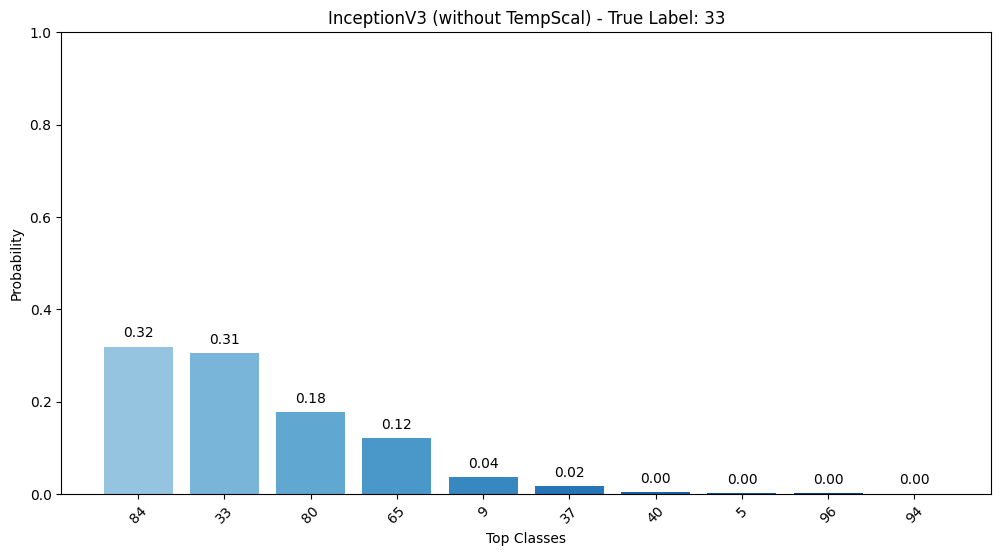

In [4]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

test_iter = iter(test_loader)
image, label = next(test_iter)
image, label = image[1].to(device), label[1].item()
model.eval()

with torch.no_grad():
    logits = model(image.unsqueeze(0))  
    probabilities = F.softmax(logits, dim=1).cpu().numpy().flatten() 

num_classes = 100
top_k = 10 

top_indices = np.argsort(probabilities)[-top_k:][::-1]
top_probs = probabilities[top_indices]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(top_k), top_probs, color=plt.cm.Blues(np.linspace(0.4, 1, top_k)))

plt.xlabel("Top Classes")
plt.ylabel("Probability")
plt.title(f"InceptionV3 (without TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks(range(top_k), top_indices, rotation=45) 

for bar, prob in zip(bars, top_probs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f"{prob:.2f}", ha='center', fontsize=10)

plt.show()

Before temperature - NLL: 1.172, ECE: 0.105
Optimal temperature: 0.633
After temperature - NLL: 1.583, ECE: 0.176


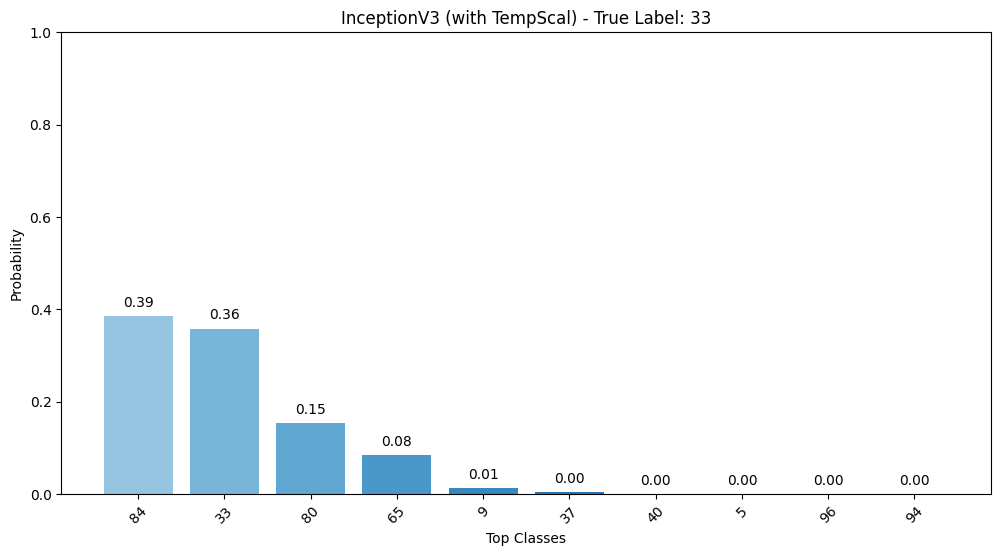

In [8]:
from src.temperature_scaling import ModelWithTemperature

model_with_temp = ModelWithTemperature(model, temperature = 0.5).to(device)
model_with_temp.set_temperature(train_loader)
model_with_temp.eval()

with torch.no_grad():
    logits = model_with_temp(image.unsqueeze(0))  
    probabilities_temp = F.softmax(logits, dim=1).cpu().numpy().flatten() 

num_classes = 100
top_k = 10 

top_indices = np.argsort(probabilities_temp)[-top_k:][::-1]
top_probs = probabilities_temp[top_indices]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(top_k), top_probs, color=plt.cm.Blues(np.linspace(0.4, 1, top_k)))

plt.xlabel("Top Classes")
plt.ylabel("Probability")
plt.title(f"InceptionV3 (with TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks(range(top_k), top_indices, rotation=45) 

for bar, prob in zip(bars, top_probs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f"{prob:.2f}", ha='center', fontsize=10)

plt.show()